### Functions that extract and load goals data from Wikipedia

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="..."></form>''')

In [828]:
from urllib import request, parse
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display


def print_df(df):
    return display(df.astype(str).style.set_table_styles([dict(selector="th",props=[('max-width', '200px')])]))

base_url = 'https://en.wikipedia.org'

def to_soup(url):
    page = request.urlopen(url)
    soup = BeautifulSoup(page)
    return soup

def correct_tag(tag, tag_type, text):
    while tag is not None:
        tag = tag.find_next(tag_type)
        if tag is None or text in tag.text:
            return tag
    return None

def get_html_table(url, from_wiki=True, text='Date', custom_dic=False):
    
    soup = to_soup(url)
    if not from_wiki:
        html_table = soup.find('table', {'class':'table matches table-condensed table-hover sortable'})
    else:
        dic = {'class':'mw-headline', 'id':'International'}
        dic['id'] += '_career' if custom_dic else ''
        tag = soup.find('span', dic)
        a = correct_tag(tag, 'a', 'List of international goals')

        # a=None means the international goals table is on this page
        if a is None:
            th = soup.find('th')
            while True:
                if text in th.text and len(th.text)<7:
                    break
                th = th.find_next('th')
            html_table = th.find_parent('table')
        # a!=None means the goals table is on a separate page that will need to be parsed again
        else:
            new_url = base_url + a['href']
            html_table = get_html_table(new_url)
    return html_table


def get_table(url, from_wiki=True, text='Date', custom_dic=False):
    html_table = get_html_table(url, from_wiki, text, custom_dic)
    table = pd.read_html(str(html_table))[0]
    if isinstance(table.columns, pd.MultiIndex):
        table.columns = [col[1] for col in table.columns]
    if not from_wiki:
        # last row is just the totals
        table = table.iloc[:-1,:].dropna(axis=1)
    if 'Date' in table.columns:
        try:
            table['Date'] = pd.to_datetime(table['Date'])
        except:
            table = (table[pd.to_numeric(table.iloc[:,0].str.split('.').str[0], errors='coerce').notnull()]
                     .dropna(axis=1))
            table['Date'] = pd.to_datetime(table['Date'])
    return table

def get_goals_table(player):
    if player == 'Carlos Ruiz':
        player += '_(Guatemalan_footballer)'
    elif player == 'Ronaldo':
        player += '_(Brazilian_footballer)'
    url = base_url + '/wiki/' + parse.quote(player.replace(' ','_'))
    print(player, end='\r')
    table = get_table(url, custom_dic=True) if player == 'Phil Younghusband' else get_table(url)
    time.sleep(10)
    return table

### Load fifa ranks data

In [593]:
fifa_ranks = pd.read_csv('fifa_ranking-2021-05-27.csv')
fifa_ranks['rank_date'] = pd.to_datetime(fifa_ranks['rank_date'])
fifa_ranks_by_year = pd.crosstab(fifa_ranks['rank'], fifa_ranks['rank_date'], 
                                 fifa_ranks['country_full'], aggfunc=','.join)
fifa_ranks_by_year = fifa_ranks_by_year.replace(np.nan, 'NaN')
country_names = np.unique(fifa_ranks['country_full'])
rank_dates = fifa_ranks_by_year.columns.values

#### List of players who have scored more than 50 international goals who debuted after FIFA rankings were introduced

In [594]:
url = "https://en.wikipedia.org/wiki/List_of_men%27s_footballers_with_50_or_more_international_goals"
players = get_table(url, text='Rank')
active_players = players[players['Career span'].str.len()<9]['Player'].tolist()
players_debut_after_1993 = players[players['Career span'].str.split('–').str[0].astype(int) > 1992]['Player'].tolist()
inactive_players = [player for player in players_debut_after_1993 if player not in active_players]

### Functions that are used to create a single DataFrame of players and number of goals

In [852]:
def country_names_standardized(srs):
    nonstandard_names = srs[~srs.isin(country_names)]
    if len(nonstandard_names) > 0:
        x = (srs
             .str.replace('&','and')
             .replace('South Korea','Korea Republic')
             .replace('Ireland','Republic of Ireland')
             .replace('Iran','IR Iran')
             .replace('Brunei','Brunei Darussalam')
             .replace('Cape Verde','Cabo Verde')
             .replace('DR Congo','Congo DR')
             .replace('FR Yugoslavia','Yugoslavia')
             .replace('Ivory Coast',"Côte d'Ivoire")
             .replace('Kyrgyzstan','Kyrgyz Republic')
             .replace('Macedonia','North Macedonia')
             .replace('North Korea','Korea DPR')
             .str.replace('Saint','St.')
             .str.replace('and the','/')
             .replace('United States','USA')
             .replace('China','China PR')
#             .replace('Guadeloupe',)
#             .replace('Martinique',)
             )
    else:
        x = srs
    #leftover = x[~x.isin(country_names)]
    #if len(leftover)>0:
    #    print(leftover.tolist())
    return x

def topX_added(df, topX):
    idxs = df['Date'] > rank_dates.min()
    cols = rank_dates[np.searchsorted(rank_dates, df.loc[idxs,'Date'].values, 'right')-1]
    ranks_on_game_day = fifa_ranks_by_year.loc[:, cols]
    for num in topX:
        # since there are countries tied on fifa ranking, 
        # i.e. two or more countries occupying the same rank on fifa_ranks_by_year, 
        # they need to be split to make a fully meaningful comparison
        relevant_ranks = ranks_on_game_day.iloc[:num,:].values.astype(str)
        opponents = df.loc[idxs,'Opponent'].values.astype(str)
        df['Top'+str(num)] = False
        df.loc[idxs,'Top'+str(num)] = (np.core.defchararray.find(relevant_ranks, opponents) != -1).any(axis=0)
    return df

def get_goals_data(tables, Xs, is_complete_stats=False):
    # count the number of times each player in tables.keys() scored against topX opposition
    goals_lst = []
    games_lst = []
    for player, df in tables.items():
        print(player+'           ', end='\r')
        df['Opponent'] = country_names_standardized(df['Opponent'])
        df = topX_added(df, Xs)
        if not is_complete_stats:
            goals_lst.append(df.loc[:,'Top'+str(min(Xs)):].sum().tolist())
        else:
            games_lst.append(df.loc[:,'Top'+str(min(Xs)):].sum().tolist())
            relevant_df = df[df['Goals']>0]
            list_to_append = relevant_df.loc[:,'Top'+str(min(Xs)):].mul(relevant_df['Goals'], axis=0).sum().tolist()
            goals_lst.append(list_to_append)
    # create a single dataframe out of goals scored against topX opposition
    out1 = pd.DataFrame(goals_lst, columns=['Top '+str(num) for num in Xs], index=tables.keys())
    out2 = pd.DataFrame(games_lst, columns=['Top '+str(num) for num in Xs], index=tables.keys())
    if is_complete_stats:
        return out1, out2
    else:
        return out1
    

def complete_stats_of_player(url):
    print(url.split('/')[-1].split('.')[0]+'    ', end='\r')
    # extract table from page
    table = get_table(url, from_wiki=False)
    # find opponents
    u,c = np.unique(table[['Home Team','Away Team.1']].values, return_counts=True)
    home_country = u[c.argmax()]
    opponents = table[['Home Team','Away Team.1']].values
    table['Opponent'] = opponents[opponents!=home_country]
    table = (table
             .rename(columns={'Event':'Competition','G':'Goals'})
             .loc[:,['Date','Opponent','Competition','Goals']])
    time.sleep(10)
    return table

Xs = [5,10,20,30,40,50,60,70,80,90,100]

#### Extract goals tables of players from Wikipedia

In [613]:
active_players_tables = {player: get_goals_table(player) for player in active_players}
inactive_players_tables = {player: get_goals_table(player) for player in inactive_players 
                           if player not in ['Landon Donovan', 'Jan Koller']}

url_kd = ['https://www.national-football-teams.com/player/1824/Jan_Koller.html', 
          'https://www.national-football-teams.com/player/7101/Landon_Donovan.html']
donovan_koller = {}
donovan_koller['Jan Koller'] = complete_stats_of_player(url_kd[0])
donovan_koller['Landon Donovan'] = complete_stats_of_player(url_kd[1])

### Goals scored of players with 50 international goals

In [830]:
sums_active = get_goals_data(active_players_tables, Xs)
sums_all = sums_active.append(get_goals_data(inactive_players_tables, Xs))
sums_all = sums_all.append(get_goals_data(donovan_koller, Xs, is_complete_stats=True)[0])
print_df(sums_active.sort_values(by=['Top 20','Top 5','Top 10'], ascending=False).head(10))

,Top 5,Top 10,Top 20,Top 30,Top 40,Top 50,Top 60,Top 70,Top 80,Top 90,Top 100
Lionel Messi,11,14,26,34,40,49,54,61,63,72,72
Cristiano Ronaldo,9,16,24,38,47,56,60,62,65,75,82
Luis Suárez,4,9,23,29,34,45,48,52,56,58,59
Neymar,5,15,21,36,41,52,57,63,69,69,69
Edinson Cavani,5,12,18,22,26,33,41,43,43,48,50
Romelu Lukaku,1,8,18,25,35,44,48,52,52,54,54
Edin Džeko,4,5,17,22,23,28,31,33,34,36,38
Zlatan Ibrahimović,2,11,15,20,25,30,31,36,36,39,42
Javier Hernández,5,10,14,23,26,31,36,38,40,46,49
Robert Lewandowski,2,5,12,15,24,32,35,38,38,42,43


### List of players with 30 international goals

In [232]:
soup = to_soup('http://www.rsssf.com/miscellaneous/century.html')
header = soup.find('h3', text='Players with 30 or More Goals')
raw_table = header.find_next('pre').text.split('\n')[5:370]
str_table = [row for row in raw_table if len(row)>3]
str_lst = [[el for el in row.split('  ') if len(el)>0] for row in str_table]

In [386]:
df = pd.DataFrame(str_lst, columns=['Name','Country','Goals','Years','Note']).iloc[:,:4].fillna(np.nan)
df.loc[[34,199],'Years'] = df.loc[[34,199],'Goals']
df.loc[[34,199],'Goals'] = df.loc[[34,199],'Country'].str.split('] ').str[1]
df.loc[[34,199],'Country'] = df.loc[[34,199],'Country'].str.split(']').str[0]

df.loc[46,'Years'] = df.loc[46,'Goals']
df.loc[46,'Goals'] = df.loc[46,'Country']
df.loc[46,'Country'] = df.loc[46,'Name'].split('[')[1]
df.loc[46,'Name'] = df.loc[46,'Name'].split('[')[0]

df.loc[127,'Goals'] = df.loc[127,'Country']
df.loc[127,'Country'] = df.loc[127,'Name'].split(' [')[1]
df.loc[127,'Name'] = df.loc[127,'Name'].split(' [')[0]
df.loc[127,'Years'] = '1992–2004'
df.loc[141,'Years'] = '1983–2004'
df.loc[89,'Years'] = '1990-2002'
df.loc[[12,89],'Goals'] = (df.loc[[12,89],'Country'].str.split(']').str[1].str.split().str[0])

isna_index = df[df.isnull().any(axis=1)].index.copy()
df.loc[isna_index,'Years'] = df.loc[isna_index,'Goals']
df.loc[isna_index,'Goals'] = df.loc[isna_index,'Country']
df.loc[isna_index,'Country'] = df.loc[isna_index,'Name'].str.split('[').str[1]
df.loc[isna_index,'Name'] = df.loc[isna_index,'Name'].str.split('[').str[0]

#df['Caps'] = (df['Goals'].str.split('(').str[1].str.strip(')').str.strip().astype(int))
df['Goals'] = df['Goals'].str.extract('(\w+)').astype(int)

df['Name'] = df['Name'].str.replace('[".\-\d]','')
#df['Country'] = df['Country'].str.replace('[','').str.replace(']','')
#df['Career start'] = df['Years'].str.extract('(\d+)').astype(int)
df['Career end'] = df['Years'].str.extract('-(\d+)')

df = (df.loc[pd.notna(df['Career end']),['Name','Goals','Career end']])
df['Career end'] = df['Career end'].astype(int)

eligible_players = df.loc[df['Career end']>=1993]

### Look up some top players with 30 international goals

In [835]:
print_df(eligible_players[(eligible_players['Goals']<50) & (eligible_players['Career end']==1998)])

,Name,Goals,Career end
82,Jürgen Klinsmann,47,1998
136,Bebeto,39,1998
164,Michael Laudrup,37,1998
171,Rashidi Yekini,37,1998


In [637]:
def extract_suker():
    url = 'http://www.rsssf.com/miscellaneous/suker-intlg.html'
    soup = to_soup(url)
    raw_table = soup.find('pre').text.split('\n')[5:-31]
    str_table = [sentence.split('  ') for sentence in raw_table]
    suker = pd.DataFrame([[s.strip() for s in lst if len(s)>0] for lst in str_table])
    suker.columns = suker.iloc[0]
    suker.drop(0, inplace=True)
    suker.loc[1] = [1,0] + suker.loc[1].tolist()[1:-1]
    mask = suker['Date'].str.isnumeric()
    suker.loc[mask,['Date','Opponent']] = suker.loc[mask,['Venue','Score']]
    suker.loc[~mask,'Goals'] = 0
    suker['Goals'] = suker['Goals'].astype(int)
    suker['Date'] = pd.to_datetime(suker['Date'])
    return suker

names = ['Hristo Stoichkov', 'Jurgen Klinsmann', 'Romario', 'Michael Laudrup', 'Dennis Bergkamp', 'Gheorghe Hagi',
         'Alan Shearer', 'Ivan Zamorano', 'Gabriel Batistuta', 'Davor Suker', 'Oliver Bierhoff', 'Rivaldo',
         'Raúl (footballer)', 'Zinedine Zidane', 'Michael Owen', 'David Trezeguet', 'Michael Ballack',
         'Dimitar Berbatov', 'Andriy Shevchenko', 'Milan Baros', 'Ronaldinho', 'Diego Forlan',
         'Lukas Podolski', 'Arjen Robben', 'Gonzalo Higuaín', 'Wesley Sneijder', 'Harry Kane', 'Karim Benzema',
         'Olivier Giroud', 'Mohamed Salah', 'Alexis Sánchez', 'Sergio Agüero', 'Thomas Müller', 'Antoine Griezmann',
         'Eduardo Vargas','Enner Valencia','Gareth Bale','Adriano (footballer, born February 1982)']

dic = {}
for name in names:
    temp_dict = {name:extract_suker()} if name == 'Davor Suker' else {name:get_goals_table(name)}
    if name == 'Jurgen Klinsmann':
        temp_dict[name].columns = ['No.','Date','Venue','Opponent','Score','Result','Competition']
        temp_dict[name] = temp_dict[name].drop(7).set_index('No.')
        temp_dict[name]['Date'] = pd.to_datetime(temp_dict[name]['Date'])
    dic.update(temp_dict)


table2 = get_goals_data(dic, Xs)

## Final results: Some tables

In [836]:
sums_all = sums_all.append(table2)
final = sums_all.sort_values(by=['Top 20','Top 5','Top 10','Top 30','Top 40','Top 50','Top 100'], ascending=False)
final.to_csv('ranks.csv')
print_df(final.head(10))

,Top 5,Top 10,Top 20,Top 30,Top 40,Top 50,Top 60,Top 70,Top 80,Top 90,Top 100
Lionel Messi,11,14,26,34,40,49,54,61,63,72,72
Cristiano Ronaldo,9,16,24,38,47,56,60,62,65,75,82
Luis Suárez,4,9,23,29,34,45,48,52,56,58,59
Neymar,5,15,21,36,41,52,57,63,69,69,69
Miroslav Klose,3,8,21,30,38,46,49,53,56,57,57
Edinson Cavani,5,12,18,22,26,33,41,43,43,48,50
Ronaldo,5,11,18,33,41,44,55,55,56,56,57
Alexis Sánchez,4,14,18,20,22,25,33,36,40,44,44
Romelu Lukaku,1,8,18,25,35,44,48,52,52,54,54
Edin Džeko,4,5,17,22,23,28,31,33,34,36,38


In [837]:
print_df(final[final['Top 5']>5].sort_values(by=['Top 5','Top 10'], ascending=False)[['Top 5']])

,Top 5,Top 10,Top 20,Top 30,Top 40,Top 50,Top 60,Top 70,Top 80,Top 90,Top 100
Lionel Messi,11,14,26,34,40,49,54,61,63,72,72
Cristiano Ronaldo,9,16,24,38,47,56,60,62,65,75,82
Hristo Stoichkov,7,9,11,11,15,16,17,19,19,20,22
Jurgen Klinsmann,7,7,14,17,22,25,26,26,26,26,28
Clint Dempsey,6,9,12,17,20,23,30,36,43,48,51


In [881]:
print_df(final[final['Top 5']>5].sort_values(by=['Top 5','Top 10'], ascending=False)[['Top 5']])
for col in ['Top 10','Top 20','Top 30','Top 40','Top 50','Top 60']:
    if col == 'Top 60':
        df_to_print = final[final[col]>=int(col.split()[1])].sort_values(by=[col,'Top 5'], ascending=False)[[col]]
    else:
        df_to_print = final[final[col]>int(col.split()[1])].sort_values(by=[col,'Top 5'], ascending=False)[[col]]
    print_df(df_to_print)

,Top 5
Lionel Messi,11
Cristiano Ronaldo,9
Hristo Stoichkov,7
Jurgen Klinsmann,7
Clint Dempsey,6


,Top 10
Cristiano Ronaldo,16
Neymar,15
Lionel Messi,14
Alexis Sánchez,14
Edinson Cavani,12
Ronaldo,11
Zlatan Ibrahimović,11


,Top 20
Lionel Messi,26
Cristiano Ronaldo,24
Luis Suárez,23
Neymar,21
Miroslav Klose,21


,Top 30
Cristiano Ronaldo,38
Neymar,36
Lionel Messi,34
Ronaldo,33


,Top 40
Cristiano Ronaldo,47
Neymar,41
Ronaldo,41


,Top 50
Cristiano Ronaldo,56
Neymar,52


,Top 60
Cristiano Ronaldo,60


In [882]:
#XX = [15]
#top15 = (get_goals_data(active_players_tables, XX)
#         .append(get_goals_data(inactive_players_tables, XX))
#         .append(get_goals_data(donovan_koller, XX, is_complete_stats=True)[0])
#         .append(get_goals_data(dic, XX)))
#ff = final.merge(top15, right_index=True, left_index=True, how='left').fillna(0).astype(int)
#ff.to_csv('all_ranks.csv')
print_df(ff[ff['Top 15']>15].sort_values(by='Top 15',ascending=False)[['Top 15']])

,Top 15
Lionel Messi,19
Cristiano Ronaldo,18
Neymar,16


* Messi, Cristiano, Klinsmann, Stoichkov and Dempsey are the only players to score >5 goals against top-5 teams
* Cristiano, Neymar, Messi, Alexis Sanchez, Cavani, Ronaldo and Zlatan are the only players to score >10 goals against top-10 teams
* Messi, Cristiano and Neymar are the only players to score >15 goals against top-15 teams
* Messi, Cristiano, Suarez, Neymar and Klose are the only players to score >20 goals against top-20 teams
* Cristiano, Neymar, Messi and Ronaldo are the only players to score >30 goals against top-30 teams
* Cristiano, Neymar and Ronaldo are the only players to score >40 goals against top-40 teams
* Cristiano and Neymar are the only players to score >50 goals against top-50 teams (Messi's on 49)
* Cristiano is the only player to score 60 goals against top-60 teams (Neymar's on 57 and Messi's on 54)

* \>5 goals against top-5 teams: Messi (11), Cristiano (9), Klinsmann (7), Stoichkov (7) and Dempsey (6)
* \>10 goals against top-10 teams: Cristiano (16), Neymar (15), Messi (14), Alexis (14), Cavani (12), Ronaldo and Zlatan (both 11)
* \>15 goals against top-15 teams: Messi (19), Cristiano (18) and Neymar (16)
* \>20 goals against top-20 teams: Messi (26), Cristiano (24), Suarez (23), Neymar and Klose (both 21)
* \>30 goals against top-30 teams: Cristiano (38), Neymar (36), Messi (34) and Ronaldo (33)
* \>40 goals against top-40 teams: Cristiano (47), Neymar and Ronaldo (both 41) (Messi's on 40)
* \>50 goals against top-50 teams: Cristiano (56) and Neymar (52) (Messi's on 49)
* 60 goals against top-60 teams: Cristiano (60) (Neymar's on 57 and Messi's on 54)

In [794]:
top3 = {player:table.loc[:,:'Competition'] for player, table in active_players_tables.items() 
        if player in ['Cristiano Ronaldo','Lionel Messi','Neymar']}
opp_ranks = np.arange(1,101)
cris_leo_ney = get_goals_data(top3, opp_ranks)

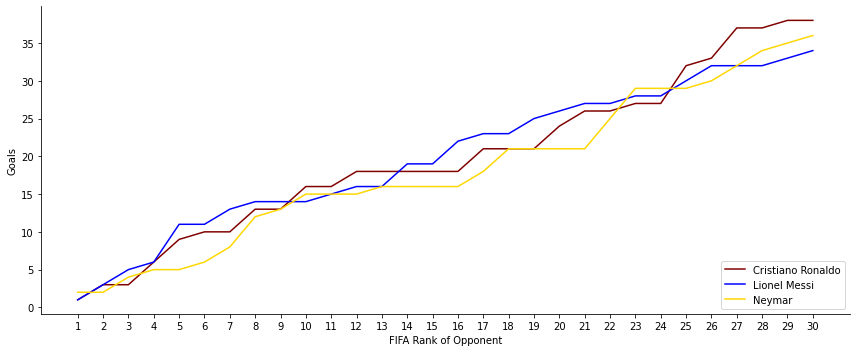

In [825]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
xrange = 30
colors = ['maroon','blue','gold']
for i, col in zip(range(3),colors):
    ax.plot(cris_leo_ney.iloc[i,:xrange].tolist(), color=col, label=cris_leo_ney.index[i])
ax.legend(loc='lower right')
ax.set_xticks(range(xrange))
ax.set_xticklabels(range(1,xrange+1))
ax.set_ylabel('Goals')
ax.set_xlabel('FIFA Rank of Opponent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout();

### To find the goal rate of some players, scrape a different website

In [4]:
url_list = ['https://www.national-football-teams.com/player/12066/Lionel_Messi.html',
            'https://www.national-football-teams.com/player/5279/Cristiano_Ronaldo.html',
            'https://www.national-football-teams.com/player/39625/Neymar.html']

complete_stats_list = {url.split('/')[-1].split('.')[0]: complete_stats_of_player(url) for url in url_list}

In [939]:
Xs = [5, 10, 15, 20, 30, 40, 50, 75, 100, 211]
top3_players = ['Lionel_Messi','Cristiano_Ronaldo','Neymar']
top3_tables = {pl:tab.loc[:,['Date','Opponent','Goals']] for pl,tab in complete_stats_list.items() if pl in top3_players}
goals_top3, games_top3 = get_goals_data(top3_tables, Xs, is_complete_stats=True)
goals_top3.columns.name = 'Goals'
games_top3.columns.name = 'Games'

#ga, go = [], []
#for pl in top3_players:
#    ga.append(complete_stats_list[pl].shape[0])
#    go.append(complete_stats_list[pl]['Goals'].sum())
#goals_top3.loc[:,'>100'] = go
#games_top3.loc[:,'>100'] = ga

In [940]:
goals_diff = goals_top3.diff(axis=1)
goals_diff['Top 5'] = goals_top3['Top 5']
goals_diff = goals_diff.astype(int)


games_diff = games_top3.diff(axis=1)
games_diff['Top 5'] = games_top3['Top 5']
games_diff = games_diff.astype(int)

cols = ['1-5','6-10','11-15','16-20','20-30','31-40','41-50','51-75','76-100','>100']
goals_diff.columns = cols
games_diff.columns = cols

goals_diff.columns.name = 'Goals'
games_diff.columns.name = 'Games'

print_df(goals_diff)
print_df(games_diff)

#goals_diff.divide(games_diff).round(2)

Goals,1-5,6-10,11-15,16-20,20-30,31-40,41-50,51-75,76-100,>100
Lionel_Messi,11,3,5,7,8,6,9,13,10,7
Cristiano_Ronaldo,9,7,2,6,14,9,9,7,19,29
Neymar,5,10,1,5,15,5,11,13,4,0


Games,1-5,6-10,11-15,16-20,20-30,31-40,41-50,51-75,76-100,>100
Lionel_Messi,24,12,12,14,19,17,14,24,11,6
Cristiano_Ronaldo,24,13,10,14,25,14,9,18,22,31
Neymar,13,20,9,15,16,12,8,18,2,0


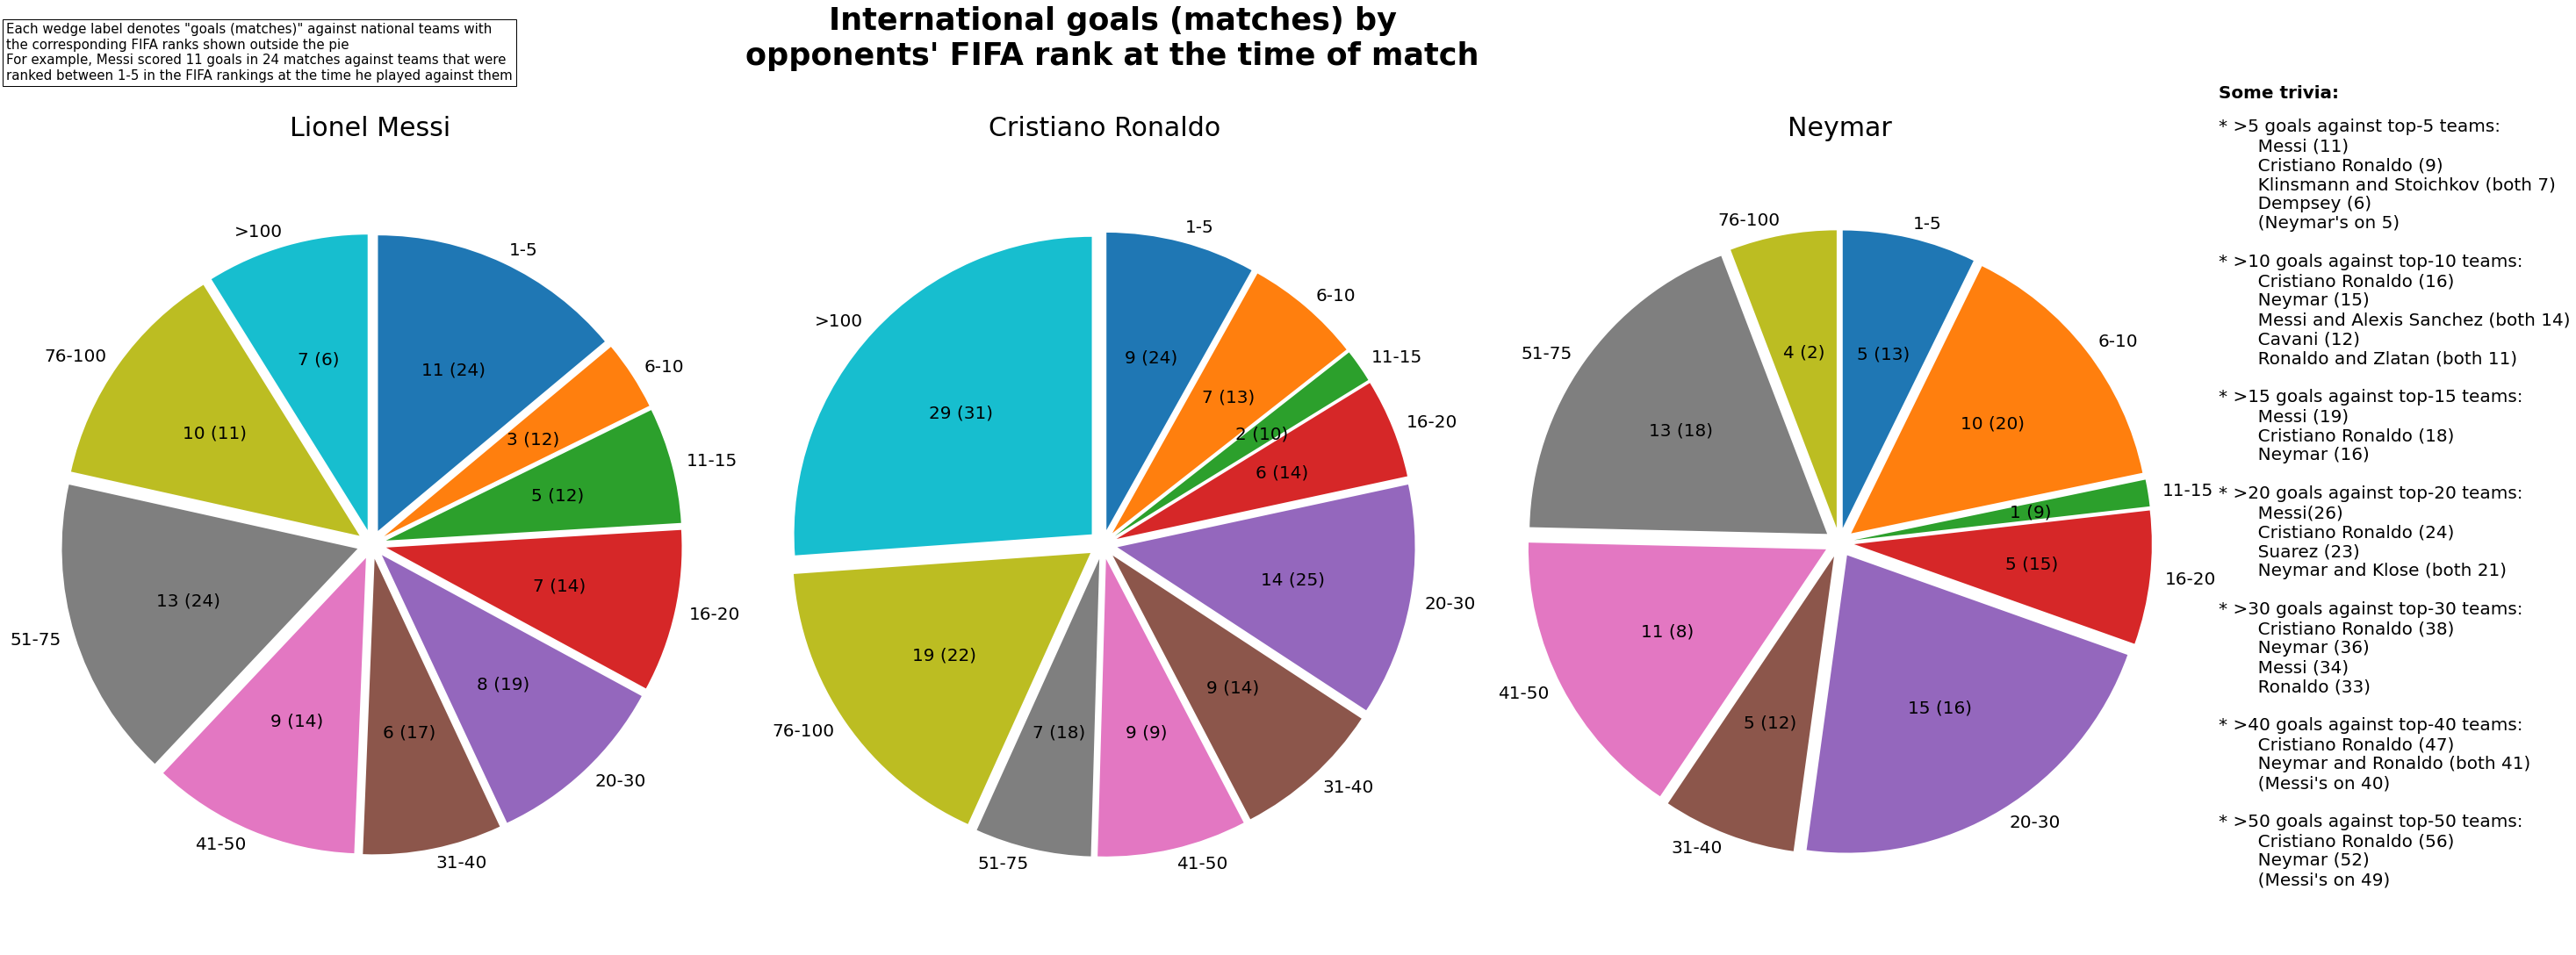

In [1119]:
trivia = ["Some trivia:", "* >5 goals against top-5 teams:\nMessi (11)\nCristiano Ronaldo (9)\nKlinsmann \
and Stoichkov (both 7)\nDempsey (6)\n(Neymar's on 5)\n* >10 goals against top-10 teams:\nCristiano Ronaldo \
(16)\nNeymar (15)\nMessi and Alexis Sanchez (both 14)\nCavani (12)\nRonaldo and Zlatan (both 11)\n* >15 goals \
against top-15 teams:\nMessi (19)\nCristiano Ronaldo (18)\nNeymar (16)\n* >20 goals against top-20 teams:\nMessi\
(26)\nCristiano Ronaldo (24)\nSuarez (23)\nNeymar and Klose (both 21)\n* >30 goals against top-30 teams:\n\
Cristiano Ronaldo (38)\nNeymar (36)\nMessi (34)\nRonaldo (33)\n* >40 goals against top-40 teams:\nCristiano \
Ronaldo (47)\nNeymar and Ronaldo (both 41)\n(Messi's on 40)\n* >50 goals against top-50 teams:\nCristiano Ronaldo \
(56)\nNeymar (52)\n(Messi's on 49)"]
max_str_len = max(len(text) for text in trivia[1].split('\n'))
trivia_text = ''
for text in trivia[1].split('\n'):
    trivia_text += (' '*7 + text if text[0]!='*' else '\n' + text) + '\n'
textprops = {'fontsize': 20}

fig, ax = plt.subplots(1,3,figsize=(35,15), constrained_layout=True, facecolor='white')
for i in range(len(goals_diff)):
    go_srs = goals_diff.iloc[i][goals_diff.iloc[i]!=0]
    ga_srs = games_diff.iloc[i][goals_diff.iloc[i]!=0]
    labels = go_srs.index.tolist()
    explode = tuple(0.05 for col in labels)
    _,_,wedgelabels = ax[i].pie(go_srs, explode=explode, labels=labels, autopct='', textprops=textprops,
                                labeldistance=1.05, startangle=90, counterclock=False)
    for j, wedgelabel in enumerate(wedgelabels):
        wedgelabel.set_text("{} ({})".format(go_srs[j],ga_srs[j]))
    ax[i].axis('equal')
    idx = goals_diff.index[i].replace('_',' ')
    ax[i].set_title(idx, fontsize=30)
fig.text(1,0.9, trivia[0], fontsize=20, fontweight='bold')
fig.text(1,0.05, trivia_text, textprops)
fig.text(0, 0.92, 
         'Each wedge label denotes "goals (matches)" against national teams with\nthe corresponding FIFA ranks \
shown outside the pie\nFor example, Messi scored 11 goals in 24 matches against teams that were\nranked between 1-5 in the FIFA rankings \
at the time he played against them', 
         fontsize=15, bbox={'boxstyle':'square','facecolor':'white'})
fig.suptitle("International goals (matches) by\nopponents' FIFA rank at the time of match\n", 
             fontsize=35, fontweight='bold');